# HP Exploratory Analysis

- Identify the novel words from the Harry Potter universe and see what kind of variability there is in those words' contextual diversity
- Play around in HP text, understand restricted domains, interesting words
    - Word frequency/locations (which book, chapter)
    - Window sizes
    - Frequency counts of HP words vs in normal databases
    - Measures of burstingness (average spacing)
    - Look into ways for organizing information (ie. CSV)

In [1]:
import pandas as pd
import numpy as np
import string
import collections
from collections import Counter
import matplotlib.pyplot as plt
import statistics
import math
import re
import os
from os import listdir
from os.path import isfile, join
from scipy.optimize import curve_fit
import pdfplumber
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package punkt to /Users/madhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/madhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Load Harry Potter Texts (Books)

In [2]:
hp_texts = pd.DataFrame(columns = ['Book No.', 'Chapter No.', 'Text'])
book_dir = "../Preprocessing/"

In [3]:
def read_chapter(path):  
    with open(path, "r", encoding ="utf8") as current_file:
        text = current_file.read()
        text = text.replace("\n", " ").replace("\r", "")
    return text

for i in range(1,8):
    filepath = book_dir + "HPBook" + str(i) +"/"
    chapters = sorted([f for f in os.listdir(filepath)])
    for c in range(len(chapters)):
        new_row = pd.DataFrame([[i, c+1, read_chapter(filepath+chapters[c])]], columns = ['Book No.', 'Chapter No.', 'Text'])
        hp_texts = pd.concat([hp_texts, new_row], ignore_index=True)

In [4]:
hp_texts

,Book No.,Chapter No.,Text
0,1,1,THE BOY WHO LIVED Mr. and Mrs. Dursley o...
1,1,2,THE VANISHING GLASS Nearly ten years ...
2,1,3,THE LETTERS FROM NO ONE The escape of...
3,1,4,THE KEEPER OF THE KEYS BOOM. They kno...
4,1,5,DIAGON ALLEY Harry woke early the nex...
...,...,...,...
193,7,32,THE ELDER WAND The world had ended so...
194,7,33,THE PRINCES TALE Harry remained kneel...
195,7,34,THE FOREST AGAIN Finally the truth. L...
196,7,35,KINGS CROSS He lay facedown listening...


## 2. Load HP Domain Specific Words

In [5]:
def load_domain_words(sheetname):
    hp_domain_file = "../../Data/HP_word_information/HP_critical_specific_words.xlsx"
    df = pd.read_excel(hp_domain_file, sheet_name=sheetname)
    return df

## 3. Word frequency/locations (which book, chapter)

In [6]:
def getWordFrequency(word):
    occurences = collections.defaultdict(list)
    
    def getWordOccurence(w, s):
        # return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search
        return Counter(w.lower() for w in re.findall(r"\w+", s))

    for index, row in hp_texts.iterrows():
        book, chapter, text = row["Book No."], row["Chapter No."], row["Text"]
        wf = dict(getWordOccurence(word, row["Text"]))
        lcw = str(word).lower()
        if lcw in wf:
            occurences[book].append((chapter, wf[lcw]))
    return occurences

In [8]:
print(getWordFrequency('Accio'))

defaultdict(<class 'list'>, {4: [(6, 4), (20, 2), (25, 1), (34, 1)], 5: [(18, 1), (22, 1), (28, 1), (29, 1), (35, 4), (36, 2)], 6: [(8, 1), (26, 1), (27, 1)], 7: [(4, 1), (6, 1), (7, 1), (10, 1), (13, 1), (14, 1), (15, 1), (17, 2), (19, 1), (26, 1), (28, 1), (31, 1)]})


In [10]:
hp1 = load_domain_words('HP1-Criticalwords')
hp1.insert(2, 'Supported WF', '')
hp1.insert(4, 'Unsupported WF', '')

for index, row in hp1.iterrows():
    hp1.at[index, "Supported WF"] = getWordFrequency(row["Supported"])
    hp1.at[index, "Unsupported WF"] = getWordFrequency(row["Unsupported"])
hp1

,HP1Item,Supported,Supported WF,Unsupported,Unsupported WF,TypeOfCriticalWord
0,1,rat,"{1: [(2, 1), (6, 5)], 2: [(3, 1), (5, 1), (8, ...",dog,"{1: [(1, 1), (3, 1), (5, 2), (9, 4), (10, 3), ...",CommonNoun
1,2,frog,"{1: [(4, 1), (6, 2), (7, 1), (12, 2), (13, 2),...",monkey,"{5: [(35, 1)], 6: [(10, 1)], 7: [(23, 1)]}",CommonNoun
2,3,Bus,"{1: [(2, 1)], 2: [(4, 1)], 3: [(3, 22), (4, 1)...",Train,"{1: [(5, 5), (6, 21), (7, 2), (8, 1), (9, 2), ...",CommonNoun/ProperName
3,4,motorcycle,"{1: [(1, 5), (2, 3)], 5: [(7, 1)], 7: [(4, 1),...",ship,"{4: [(15, 2), (16, 1), (18, 1), (19, 1), (20, ...",CommonNoun
4,5,goblins,"{1: [(5, 7), (8, 1)], 4: [(9, 1), (24, 14), (3...",monsters,"{2: [(11, 1), (13, 1), (14, 1), (15, 2), (16, ...",CommonNoun
...,...,...,...,...,...,...
103,104,Riddikulus,"{3: [(7, 10), (12, 1)], 4: [(31, 1)], 5: [(9, ...",Fiendfyre,"{7: [(31, 2)]}",ProperName
104,105,Norris,"{1: [(8, 3), (9, 5), (12, 2), (16, 2)], 2: [(8...",Lestrange,"{5: [(6, 3), (23, 3), (25, 2), (26, 1), (35, 2...",ProperName
105,106,Umbridge,"{5: [(8, 2), (11, 13), (12, 49), (13, 21), (14...",Figg,"{1: [(2, 3), (3, 2)], 4: [(7, 1), (36, 1)], 5:...",ProperName
106,107,cave,"{4: [(27, 11), (28, 1), (30, 1)], 5: [(20, 5),...",volcano,{},CommonNoun/ProperName


In [11]:
hp2 = load_domain_words('HP2-Criticalwords')
hp2.insert(2, 'WF', '')

for index, row in hp2.iterrows():
    hp2.at[index, "WF"] = getWordFrequency(row["Critical word GREEN=search on singular"])

In [12]:
hp2=hp2.rename(columns = {'Critical word GREEN=search on singular':'Word'})
hp2

,HP2Item,Word,WF,TypeOfCriticalWord
0,1,Quidditch,"{1: [(5, 6), (6, 2), (7, 1), (9, 8), (10, 7), ...",HPWorldNoun
1,2,Fire,"{1: [(3, 1), (4, 3), (5, 2), (8, 3), (10, 1), ...",CommonNoun
2,3,Hogwarts,"{1: [(4, 14), (5, 17), (6, 13), (7, 9), (8, 2)...",HPProperName
3,4,owl,"{1: [(1, 5), (4, 6), (5, 13), (6, 7), (9, 2), ...",CommonNoun
4,5,Prince,"{1: [(8, 1)], 5: [(37, 1)], 6: [(9, 2), (10, 4...",CommonNoun
...,...,...,...,...
167,168,smile,"{1: [(1, 2), (3, 1), (4, 1), (5, 1), (6, 2), (...",CommonNoun
168,169,nargles,"{5: [(21, 4)], 7: [(22, 1)]}",HPWorldNoun
169,170,Sneakoscope,"{3: [(1, 2), (5, 4), (11, 4)], 4: [(20, 2), (2...",HPWorldNoun
170,171,thestrals,"{5: [(17, 3), (21, 12), (27, 1), (30, 2), (33,...",HPWorldNoun


In [13]:
hp3 = load_domain_words('HP3-Criticalwords')
hp3.insert(2, 'Supported WF', '')
hp3.insert(4, 'Related WF', '')
hp3.insert(6, 'Unrelated WF', '')

for index, row in hp3.iterrows():
    hp3.at[index, "Supported WF"] = getWordFrequency(row["Supported"])
    hp3.at[index, "Related WF"] = getWordFrequency(row["Related"])
    hp3.at[index, "Unrelated WF"] = getWordFrequency(row["Unrelated"])
hp3

,HP3Item,Supported,Supported WF,Related,Related WF,Unrelated,Unrelated WF,TypeOfSupported
0,1,goblins,"{1: [(5, 7), (8, 1)], 4: [(9, 1), (24, 14), (3...",werewolves,"{1: [(15, 2)], 2: [(4, 1), (6, 1), (15, 1), (1...",Alohomora,"{1: [(9, 1), (16, 1)], 3: [(21, 1)], 5: [(23, ...",CommonNoun
1,2,centaurs,"{1: [(15, 5)], 2: [(15, 1)], 5: [(7, 1), (9, 1...",unicorns,"{1: [(5, 1), (15, 3)], 2: [(15, 1)], 4: [(24, ...",Errol,"{2: [(3, 1), (4, 3), (6, 3)], 3: [(1, 5), (2, ...",CommonNoun
2,3,Quaffle,"{1: [(10, 10), (11, 9)], 2: [(7, 2)], 3: [(8, ...",snitch,"{1: [(10, 4), (11, 8), (13, 4), (17, 2)], 2: [...",Krum,"{4: [(5, 1), (7, 6), (8, 20), (9, 5), (11, 2),...",HPWorldNoun
3,4,Divination,"{2: [(14, 1)], 3: [(4, 3), (6, 10), (12, 2), (...",Transfiguration,"{1: [(5, 2), (7, 1), (8, 1), (16, 1)], 2: [(4,...",basilisk,"{2: [(16, 14), (17, 13), (18, 2)], 4: [(17, 1)...",HPWorldNoun
4,5,Transfiguration,"{1: [(5, 2), (7, 1), (8, 1), (16, 1)], 2: [(4,...",Arithmancy,"{2: [(14, 1)], 3: [(4, 1), (6, 5), (12, 5), (1...",Alley,"{1: [(5, 3), (6, 4), (17, 1)], 2: [(4, 13), (1...",HPWorldNoun
...,...,...,...,...,...,...,...,...
151,152,Glory,"{1: [(2, 1), (8, 1)], 2: [(4, 1)], 3: [(10, 1)...",Knockturn,"{2: [(4, 6), (14, 1)], 6: [(6, 3), (7, 1), (17...",Gryffindor,"{1: [(6, 2), (7, 13), (8, 4), (9, 9), (10, 5),...",CommonNoun
152,153,Kreacher,"{5: [(4, 3), (6, 41), (9, 2), (14, 5), (16, 1)...",locket,"{5: [(6, 1)], 6: [(10, 1), (13, 2), (17, 2), (...",owl,"{1: [(1, 5), (4, 6), (5, 13), (6, 7), (9, 2), ...",ProperName
153,154,portrait,"{1: [(7, 2), (9, 6), (10, 1), (12, 1), (13, 1)...",password,"{1: [(7, 1), (9, 1)], 2: [(5, 3), (11, 1), (12...",tail,"{1: [(1, 1), (2, 2), (4, 1), (5, 2), (6, 2), (...",CommonNoun
154,155,Quidditch,"{1: [(5, 6), (6, 2), (7, 1), (9, 8), (10, 7), ...",broomstick,"{1: [(6, 1), (9, 10), (10, 9), (11, 3), (12, 1...",Nick,"{1: [(7, 3), (8, 1)], 2: [(8, 31), (11, 7), (1...",ProperName


In [14]:
hp3x = load_domain_words('HP3_HPworld-Criticalwords-only')
hp3x.insert(3, 'Word WF', '')
hp3x.insert(5, 'Alternate form WF', '')

for index, row in hp3x.iterrows():
    hp3x.at[index, "Word WF"] = getWordFrequency(row["Word"])
    hp3x.at[index, "Alternate form WF"] = getWordFrequency(row["Alternate form"])
hp3x

,HP3Item,Category,Word,Word WF,Alternate form,Alternate form WF
0,1,Magical creature--being,goblins,"{1: [(5, 7), (8, 1)], 4: [(9, 1), (24, 14), (3...",NaN,{}
1,1,Magical creature--being,werewolves,"{1: [(15, 2)], 2: [(4, 1), (6, 1), (15, 1), (1...",NaN,{}
2,2,Magical creature--beast,centaurs,"{1: [(15, 5)], 2: [(15, 1)], 5: [(7, 1), (9, 1...",NaN,{}
3,2,Magical creature--beast,unicorns,"{1: [(5, 1), (15, 3)], 2: [(15, 1)], 4: [(24, ...",NaN,{}
4,3,Ball used in Quidditch,Quaffle,"{1: [(10, 10), (11, 9)], 2: [(7, 2)], 3: [(8, ...",NaN,{}
...,...,...,...,...,...,...
126,146,Location--dwelling,Burrow,"{2: [(3, 2), (4, 3), (5, 1)], 3: [(10, 1)], 4:...",NaN,{}
127,149,Magical artifact--other,cauldron,"{1: [(5, 10), (6, 1), (7, 1), (8, 5), (17, 1)]...",NaN,{}
128,154,Magical artifact--other,Portraits,"{1: [(7, 1), (8, 1)], 2: [(5, 1), (12, 1), (13...",NaN,{}
129,155,Game,Quidditch,"{1: [(5, 6), (6, 2), (7, 1), (9, 8), (10, 7), ...",NaN,{}


In [15]:
hp_additional = load_domain_words('Additional HP words')
hp_additional.insert(2, 'WF', '')

for index, row in hp_additional.iterrows():
    hp_additional.at[index, "WF"] = getWordFrequency(row["Word"])
hp_additional

,Category,Word,WF
0,Game,Gobstones,"{3: [(4, 1), (11, 1), (16, 1)], 4: [(20, 1)], ..."
1,Group of wizards,Unspeakables,"{4: [(7, 1)], 5: [(24, 1)], 7: [(12, 1)]}"
2,Location--Diagon Alley,Eeylops,"{1: [(5, 2)], 6: [(6, 2)]}"
3,Location--Hogsmeade,Gladrags,"{4: [(8, 1), (27, 1)]}"
4,Location--prison,Nurmengard,"{7: [(18, 2), (24, 1), (25, 1), (35, 1)]}"
...,...,...,...
183,Type of wizard pet,frog,"{1: [(4, 1), (6, 2), (7, 1), (12, 2), (13, 2),..."
184,Type of wizard pet,rat,"{1: [(2, 1), (6, 5)], 2: [(3, 1), (5, 1), (8, ..."
185,Type of wizard pet,spider,"{1: [(2, 1)], 2: [(9, 1), (15, 9)], 3: [(1, 1)..."
186,Wizarding exam,N.E.W.T.s,{}


In [48]:
list_of_dataframes = [hp1, hp2, hp3, hp3x, hp_additional]
for count, dataframe in enumerate(list_of_dataframes):
    dataframe.to_csv(f"../Results/WF_outputs/wf_hp_{count+1}.csv", index=False)

## 4. SUBTLEX Word frequency

https://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexus

https://link.springer.com/article/10.3758/s13428-018-1077-9#Sec9

In [17]:
df_subtlex = pd.read_csv("../../Data/WF_databases/SUBTLEXusfrequencyabove1.csv")
len(df_subtlex)
df_subtlex.head(5)

,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD
0,the,1501908,8388,1339811,8388,29449.18,6.1766,100.00,3.9237
1,to,1156570,8383,1138435,8380,22677.84,6.0632,99.94,3.9235
2,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234
3,you,2134713,8381,1595028,8376,41857.12,6.3293,99.92,3.9233
4,and,682780,8379,515365,8374,13387.84,5.8343,99.89,3.9232


(array([6.0341e+04, 2.7000e+01, 6.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([2.0000000e+00, 2.1347310e+05, 4.2694420e+05, 6.4041530e+05,
        8.5388640e+05, 1.0673575e+06, 1.2808286e+06, 1.4942997e+06,
        1.7077708e+06, 1.9212419e+06, 2.1347130e+06]),
 <BarContainer object of 10 artists>)

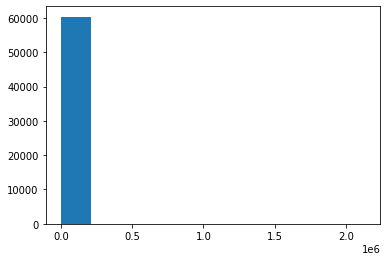

In [18]:
plt.hist(df_subtlex['FREQcount'])

(array([2.5347e+04, 1.6087e+04, 1.0149e+04, 5.1570e+03, 2.3220e+03,
        8.2300e+02, 3.3000e+02, 1.0600e+02, 5.2000e+01, 1.1000e+01]),
 array([0.4771 , 1.06232, 1.64754, 2.23276, 2.81798, 3.4032 , 3.98842,
        4.57364, 5.15886, 5.74408, 6.3293 ]),
 <BarContainer object of 10 artists>)

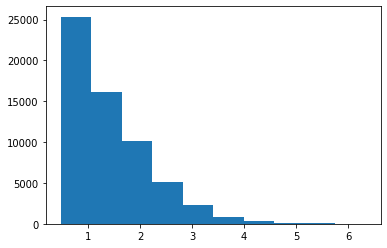

In [19]:
plt.hist(df_subtlex['Lg10WF'])

In [20]:
df_subtlex['rank_frequency'] = df_subtlex['Lg10WF'].rank(ascending = False)
df_subtlex.head(5)

,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD,rank_frequency
0,the,1501908,8388,1339811,8388,29449.18,6.1766,100.00,3.9237,3.0
1,to,1156570,8383,1138435,8380,22677.84,6.0632,99.94,3.9235,4.0
2,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234,6.0
3,you,2134713,8381,1595028,8376,41857.12,6.3293,99.92,3.9233,1.0
4,and,682780,8379,515365,8374,13387.84,5.8343,99.89,3.9232,10.0


In [21]:
def zipf(x, a, b):
    """Zipf's law, where x = rank, and a&b are the parameters to learn."""
    return a / (x**b)

df_frequencies_top_n = df_subtlex[df_subtlex['rank_frequency']<1000]
x = df_frequencies_top_n['rank_frequency'].values
y = df_frequencies_top_n['Lg10WF'].values
z_popt, z_pcov = curve_fit(zipf, x, y)
y_pred = zipf(x, *z_popt)
df_frequencies_top_n['y_pred'] = y_pred

/var/folders/4r/533dz09x56z9y2_cd1mz_wb40000gn/T/ipykernel_2613/4234201932.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frequencies_top_n['y_pred'] = y_pred


In [22]:
df_merged = pd.merge(hp2, 
                     df_subtlex[['Word', 'Lg10WF']], 
                     on="Word")
df_merged

,HP2Item,Word,WF,TypeOfCriticalWord,Lg10WF
0,4,owl,"{1: [(1, 5), (4, 6), (5, 13), (6, 7), (9, 2), ...",CommonNoun,2.4579
1,5,Prince,"{1: [(8, 1)], 5: [(37, 1)], 6: [(9, 2), (10, 4...",CommonNoun,3.3617
2,6,wand,"{1: [(4, 1), (5, 28), (6, 7), (7, 2), (8, 3), ...",CommonNoun,2.1987
3,10,dog,"{1: [(1, 1), (3, 1), (5, 2), (9, 4), (10, 3), ...",CommonNoun,3.9928
4,12,car,"{1: [(1, 3), (2, 8), (3, 5), (4, 3), (6, 1)], ...",CommonNoun,4.3916
...,...,...,...,...,...
57,158,Hermes,"{2: [(3, 1)], 3: [(5, 1)], 4: [(5, 1)], 5: [(1...",ProperNameInEnglish,1.4624
58,159,necklace,"{2: [(4, 1)], 5: [(10, 1), (20, 1)], 6: [(6, 1...",CommonNoun,2.6972
59,163,Friar,"{1: [(7, 4)], 2: [(8, 1)], 4: [(12, 1)], 5: [(...",CommonNoun,1.9494
60,165,flute,"{1: [(12, 1), (16, 5)]}",CommonNoun,2.0374


# ** Archive **

## 5. Word frequency/locations (which movie, page) - LATER

In [44]:
with pdfplumber.open('../../Data/Movie2_script.pdf') as pdf:
    first_page = pdf.pages[0]
    print(first_page.extract_text())

 
               
 
                   HARRY POTTER AND 
 
 
               THE CHAMBER OF SECRETS 
 
 
              screenplay by STEVEN KLOVES 
 
 
 
                 based on the novel by 
 
                     J.K. ROWLING 
 
 
 
 
 
 
    FADE IN: 
 
 
 
 
 
 
 
 
1   EXT. PRIVET DRIVE - DAY                                     1 
 
    WIDE HELICOPTER SHOT. Privet Drive. CAMERA CRANES DOWN, 
    DOWN, OVER the rooftops, FINDS the SECOND FLOOR WINDOW of 
    NUMBER 4. HARRY POTTER sits in the window. 
 
 
 
 
2   OMITTED                                                     2 
 
 
 
 
 
3   INT. HARRY'S BEDROOM - DAY                                  3 
 
    Harry pages through a SCRAPBOOK, stops on a MOVING PHOTO 
    of Ron and Hermione. SQUAWK! Harry jumps. HEDWIG pecks 
    at the LOCK slung through her cage door, then glowers at 
    Harry. 
 
                             HARRY 
 
               I can't, Hedwig. I'm not allowed 
               to use magic outside of school. 
